In [2]:
# For Google Colaboratory

#!pip install torchinfo
#!unzip training.zip

In [3]:
#!conda env export > environment.yml

In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms
from torchinfo import summary
import numpy as np
import matplotlib.pyplot as plt
import os

from src.road_segmentation.utils import *

In [5]:
import warnings

device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
if device == "cpu":
    warnings.warn("CUDA not detected, training will be very slow")

device = torch.device(device)

C:\Users\calle\AppData\Local\Temp/ipykernel_22008/1650804771.py:5: UserWarning: CUDA not detected, training will be very slow
  warnings.warn("CUDA not detected, training will be very slow")


# Dataset loading

In [16]:
IMAGE_SRC_DIR = "data/training/images/"
IMAGE_GT_DIR = "data/training/groundtruth/"

IMAGE_SRC_DIR2 = "data/training/extimages/"
IMAGE_GT_DIR2 = "data/training/extgt/"

IMAGES_SRC = np.asarray(read_all_images(IMAGE_SRC_DIR))
IMAGES_GT = np.asarray(read_all_images(IMAGE_GT_DIR))

IMAGES_SRC2 = np.asarray(read_all_images(IMAGE_SRC_DIR2)).astype(float) / 255.0
IMAGES_GT2 = np.asarray(read_all_images(IMAGE_GT_DIR2)).astype(float) / 255.0



print(IMAGES_SRC2.shape)
print(IMAGES_SRC[0][100][100])

(12, 1500, 1500, 3)
[0.43137255 0.4392157  0.40784314]


In [17]:
#IMAGES_SRC = IMAGES_SRC[:10, ...]
#IMAGES_GT = IMAGES_GT[:10, ...]
print(IMAGES_SRC2[0][100])

[[0.56078431 0.45098039 0.34117647]
 [0.41568627 0.32941176 0.29411765]
 [0.40784314 0.30196078 0.28235294]
 ...
 [0.14901961 0.24313725 0.15686275]
 [0.11764706 0.24313725 0.16078431]
 [0.19215686 0.24705882 0.16470588]]


# Augment data

Testing multiple examples

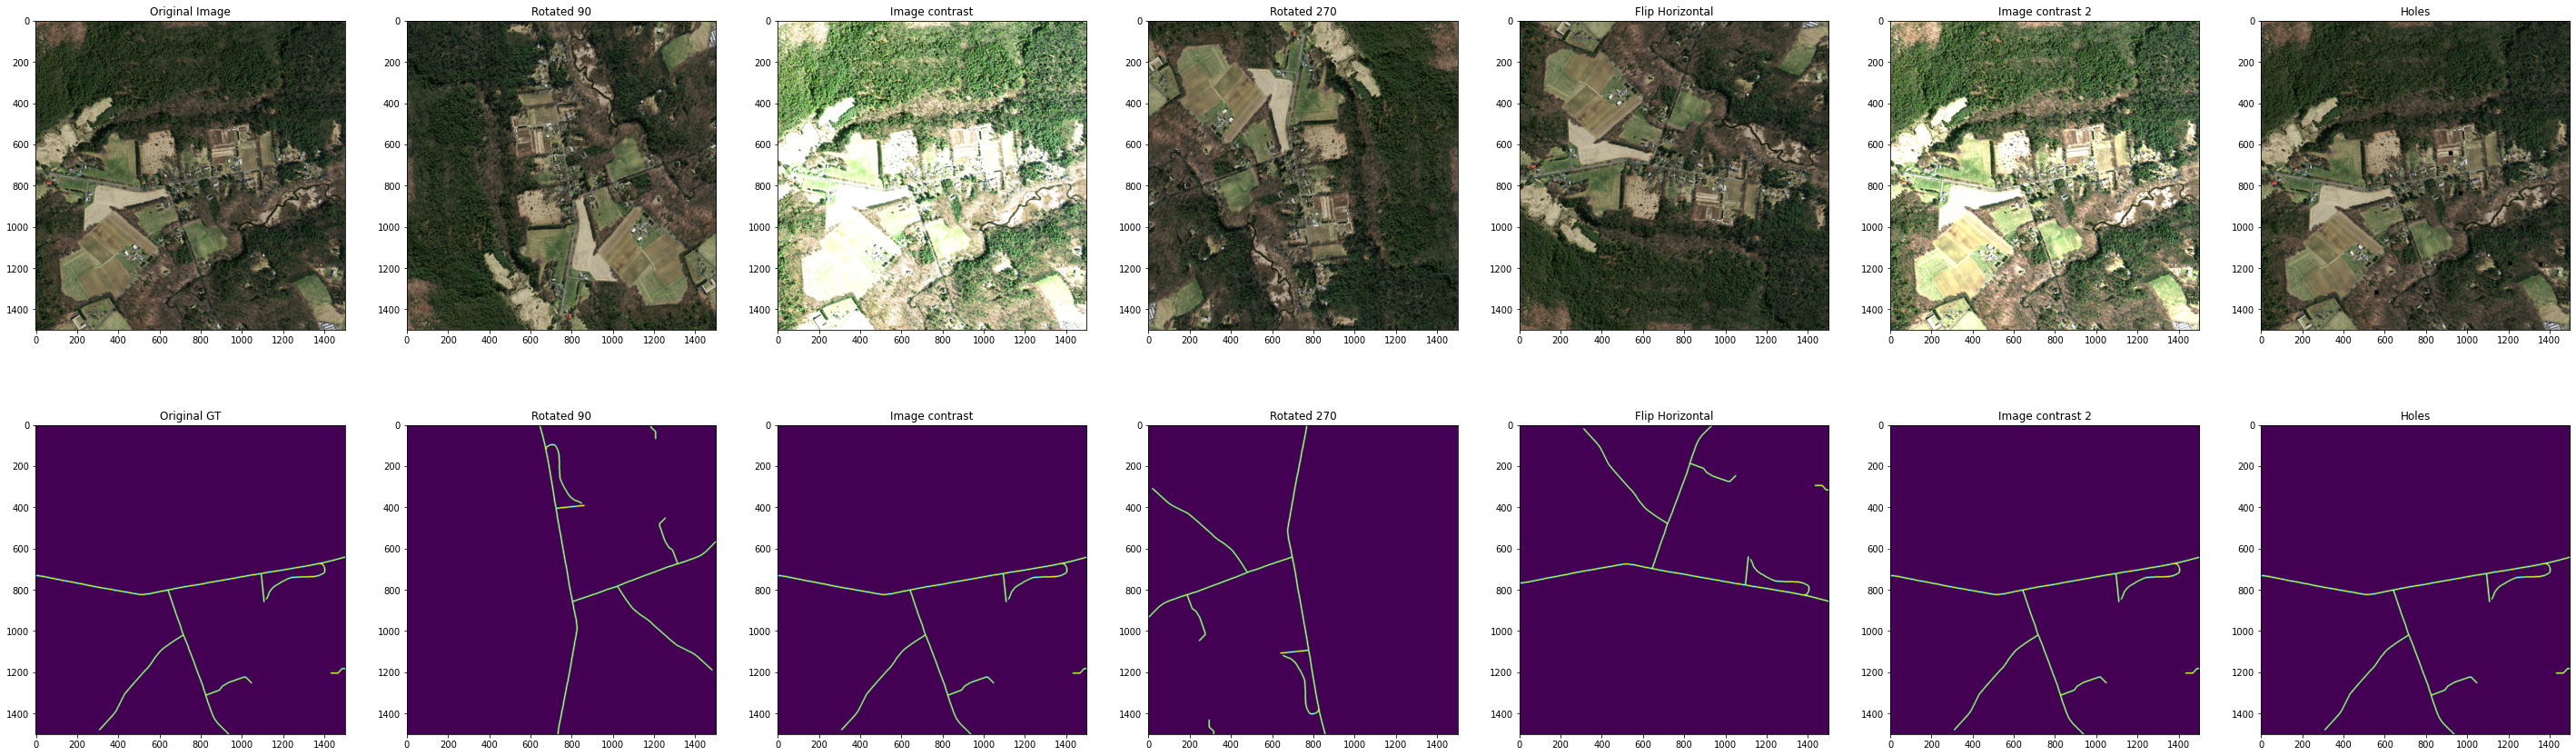

In [18]:
visualize_augmented_data(IMAGES_SRC2[:-8:-1], IMAGES_GT2[:-8:-1])

In [9]:
augmented_src, augmented_gt = augment_data(IMAGES_SRC, IMAGES_GT)
augmented_src2, augmented_gt2 = augment_data(IMAGES_SRC2, IMAGES_GT2)
#augmented_src, augmented_gt = IMAGES_SRC, IMAGES_GT
print(augmented_src.shape)
print(augmented_gt.shape)

(1300, 400, 400, 3)
(1300, 400, 400)


## crop

In [10]:
PATCH_SIZE = 100
cropped_src1, cropped_gt1 = np.asarray([img_crop(img, PATCH_SIZE, PATCH_SIZE) for img in augmented_src]).reshape((-1, PATCH_SIZE, PATCH_SIZE, 3)), np.asarray([img_crop(img, PATCH_SIZE, PATCH_SIZE) for img in augmented_gt]).reshape((-1, PATCH_SIZE, PATCH_SIZE))
cropped_src2, cropped_gt2 = np.asarray([img_crop(img, PATCH_SIZE, PATCH_SIZE) for img in augmented_src2]).reshape((-1, PATCH_SIZE, PATCH_SIZE, 3)), np.asarray([img_crop(img, PATCH_SIZE, PATCH_SIZE) for img in augmented_gt2]).reshape((-1, PATCH_SIZE, PATCH_SIZE))
cropped_src = np.concatenate([cropped_src1, cropped_src2], axis=0)
cropped_gt = np.concatenate([cropped_gt1, cropped_gt2], axis=0)
print(cropped_src.shape)
print(cropped_gt.shape)


(55900, 100, 100, 3)
(55900, 100, 100)


# Normalization

In [11]:
def get_mean_std(imgs):
  """
  Normalizes images with mean and standard deviation, by channel
  """
  mean = imgs.mean(axis=(0, 1, 2))
  std = imgs.std(axis=(0, 1, 2))

  return mean, std

means, stds = get_mean_std(cropped_src)

KeyboardInterrupt: 

# Dataset loading

In [ ]:
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(means, stds)
])

ds_src, ds_gt = torch.stack([img_transform(i) for i in cropped_src]), torch.stack([transforms.ToTensor()(i) for i in cropped_gt]).squeeze()
print(ds_src.shape)
print(ds_gt.shape)

torch.Size([17600, 3, 100, 100])
torch.Size([17600, 100, 100])


In [ ]:
dataset = TensorDataset(ds_src, ds_gt)

## + splitting

In [ ]:
def split_dataset(dataset):
  train_size = int(len(dataset) * 0.8)
  test_size = len(dataset) - train_size
  return torch.utils.data.random_split(dataset, [train_size, test_size])

train_ds, test_ds = split_dataset(dataset)

# Model definition

In [ ]:
from road_segmentation.models import UNet

model=UNet(n_channels=3, n_classes=1)
summary(model, input_size=(6, 3, PATCH_SIZE, PATCH_SIZE))

Layer (type:depth-idx)                        Output Shape              Param #
UNet                                          [6, 100, 100]             --
├─DoubleConv: 1-1                             [6, 64, 100, 100]         --
│    └─Sequential: 2-1                        [6, 64, 100, 100]         --
│    │    └─Conv2d: 3-1                       [6, 64, 100, 100]         1,728
│    │    └─BatchNorm2d: 3-2                  [6, 64, 100, 100]         128
│    │    └─ReLU: 3-3                         [6, 64, 100, 100]         --
│    │    └─Conv2d: 3-4                       [6, 64, 100, 100]         36,864
│    │    └─BatchNorm2d: 3-5                  [6, 64, 100, 100]         128
│    │    └─ReLU: 3-6                         [6, 64, 100, 100]         --
├─Down: 1-2                                   [6, 128, 50, 50]          --
│    └─Sequential: 2-2                        [6, 128, 50, 50]          --
│    │    └─MaxPool2d: 3-7                    [6, 64, 50, 50]           --
│    │    └

# Training!

In [ ]:
def fgsm_update(image, data_grad, update_max_norm):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + update_max_norm * sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

In [ ]:
from tqdm.notebook import tqdm
def train_epoch(model, device, train_loader, optimizer, epoch, criterion):
    model.train()

    loss_history = []
    acc_history = []
    t = tqdm(enumerate(train_loader), total=len(train_loader))
    for batch_idx, (data, target) in t:
        data, target = data.to(device), target.to(device)
        data.requires_grad = True
        optimizer.zero_grad()
        output = model.forward(data)#[None, ...]
        loss = criterion(output, target)
        loss.backward()

        # perturbed_data = fgsm_update(data, data.grad, 0.1)
        # output = model(perturbed_data)
        # loss = criterion(output, target)
        # optimizer.zero_grad()
        # loss.backward()
        optimizer.step()
        loss_history.append(loss.item())
        t.set_postfix({"loss": loss.item()})
        acc_history.append(((output > 0).eq(target > 0).sum() / target.numel()).item())

    return acc_history, loss_history

In [ ]:
def train(device, batch_size=32, epochs=60):
    pytorchDl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.002)
    criterion = nn.BCEWithLogitsLoss()

    for i in tqdm(range(epochs)):
        acc_history, loss_history = train_epoch(model, device, pytorchDl, optimizer, i, criterion)
        if i % 1 == 0:
          print("Epoch: ", i, " Accuracy: ", sum(acc_history)/len(acc_history), " Loss: ", sum(loss_history)/len(loss_history))
        if i%1==0:
          print("saving…")
          torch.save(model.state_dict(), "./checkpoint_{}.pth".format(i))
        if i%1 == 0:
          f1 = compute_f1(test_ds, model, device, threshold=0.10)
          print("F1: ", f1)
          f1 = compute_f1(test_ds, model, device, threshold=0.18)
          print("F1: ", f1)
          f1 = compute_f1(test_ds, model, device, threshold=0.25)
          print("F1: ", f1)
          f1 = compute_f1(test_ds, model, device, threshold=0.5)
          print("F1: ", f1)
          f1 = compute_f1(test_ds, model, device, threshold=0.75)
          print("F1: ", f1)

    return

In [ ]:
#model.load_state_dict(torch.load("checkpoints/UNet_145.pth"))
torch.save(model.state_dict(), "./checkpoints/antoine_last.pt")

In [ ]:
train(device, 70, 30)

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Visualize results?

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 100, 100])


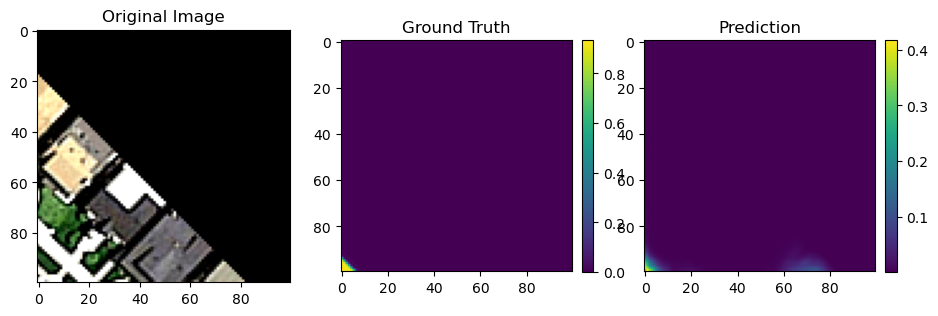

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 100, 100])


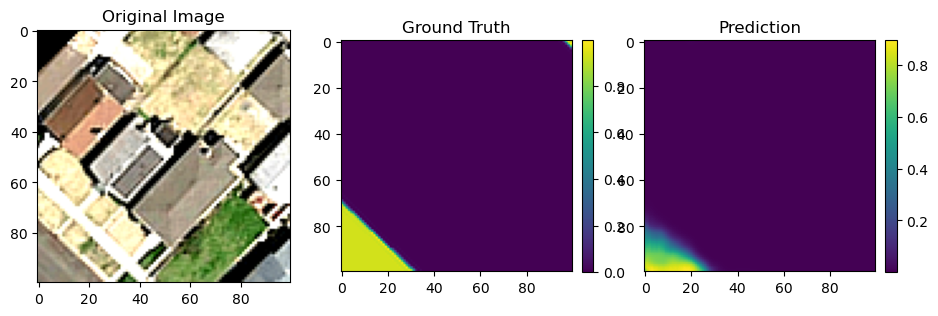

In [ ]:
visualize_result(device, model, train_ds)
visualize_result(device, model, test_ds)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


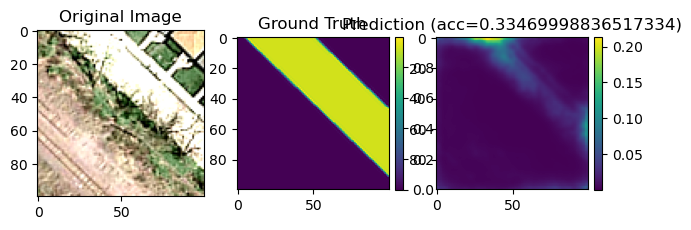

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


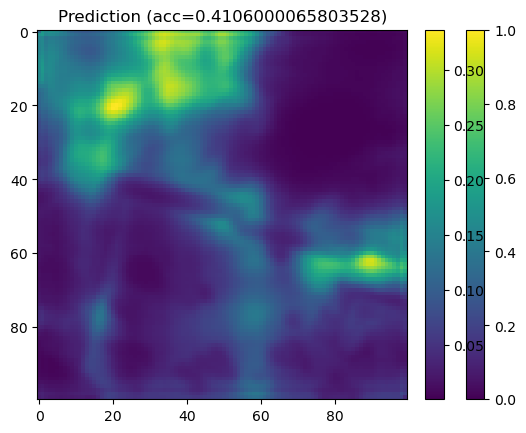

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


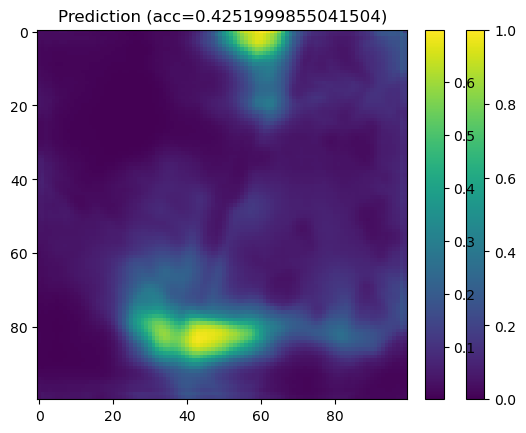

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


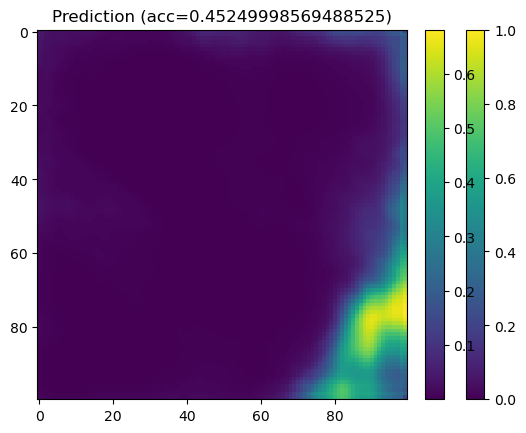

In [ ]:
dl = DataLoader(train_ds, batch_size=1, shuffle=True)

N = 1000

acc_dict = {}

for batch_idx, (data, target) in enumerate(dl):
    data, target = data.to(device), target.to(device)
    output = model.forward(data)

    acc = ((output > 0).eq(target > 0).sum() / target.numel()).item()

    acc_dict[acc] = (data, target)

    if batch_idx >= N:
      break

k = 4
top_k = []

accs = sorted(list(acc_dict.keys()))

top_k = [
    (accs[i], acc_dict[accs[i]])
    for i in range(min(len(accs), k))
]

m = len(top_k)

from math import ceil
cols = 3*2 # 2 sets of 3 images
rows = ceil(m/2)

fig = plt.figure(figsize=(15, 15))

for i, (acc, (data, target)) in enumerate(top_k):
    idx = i*3

    data = data.squeeze()
    target = target.squeeze()

    inputs = data.to(device).unsqueeze(0)

    output = model.forward(inputs)

    data, target = data.cpu().numpy().transpose((1, 2, 0)), target.cpu().numpy()

    fig.add_subplot(rows, cols, idx+1)
    im = plt.imshow(data)
    plt.title("Original Image")

    fig.add_subplot(rows, cols, idx+2)
    im = plt.imshow(target)
    fig.colorbar(im, fraction=0.046, pad=0.04)
    plt.title("Ground Truth")

    fig.add_subplot(rows, cols, idx+3)
    im = plt.imshow(nn.Sigmoid()(output.cpu().detach()).numpy())
    fig.colorbar(im, fraction=0.046, pad=0.04)
    plt.title(f"Prediction (acc={acc})")

    plt.show()

# Making a submission

In [ ]:
import time

TEST_SET_FOLDER = os.path.abspath("data/test_set_images")
SUBMISSION_NAME = f"submission_{time.time()}.csv"

SUBMISSION_PATH = os.path.abspath("submissions/" + SUBMISSION_NAME)

make_submission(model, device, img_transform, SUBMISSION_PATH, TEST_SET_FOLDER)